# Week 1 Seminar

A/B experiment analysis

In [200]:
import glob
from collections import namedtuple

import pandas as pd
import numpy as np
import scipy.stats as ss

import matplotlib.pyplot as plt

pd.set_option("display.precision", 3)

%matplotlib inline

In [201]:
experiment = "HW2"

In [202]:
data = pd.concat([
    pd.read_json(data_path, lines=True)
    for data_path
    in glob.glob("../rec_sys_data/*/data.json")
])

data["treatment"] = data["experiments"].map(lambda experiments: experiments[experiment])

In [203]:
data

,message,timestamp,user,track,time,latency,recommendation,experiments,treatment
0,next,2025-05-11 19:53:49.538,1520,14617,1.00,1.934e-03,10610.0,{'HW2': 'C'},C
1,next,2025-05-11 19:53:49.589,1520,14617,0.00,2.712e-03,6721.0,{'HW2': 'C'},C
2,next,2025-05-11 19:53:49.628,9759,6995,0.64,1.546e-03,12489.0,{'HW2': 'C'},C
3,next,2025-05-11 19:53:49.650,9759,10225,0.26,9.699e-04,9729.0,{'HW2': 'C'},C
4,next,2025-05-11 19:53:49.684,432,37727,0.00,2.135e-03,37728.0,{'HW2': 'T1'},T1
...,...,...,...,...,...,...,...,...,...
12311,next,2025-05-11 20:06:37.723,5813,24742,0.49,3.975e-03,23541.0,{'HW2': 'T1'},T1
12312,next,2025-05-11 20:06:37.878,8421,20746,0.80,7.315e-04,27440.0,{'HW2': 'T1'},T1
12313,next,2025-05-11 20:06:37.972,7760,42806,0.33,1.104e-03,42275.0,{'HW2': 'C'},C
12314,next,2025-05-11 20:06:38.014,9567,46981,0.64,5.901e-04,34847.0,{'HW2': 'C'},C


In [204]:
data.groupby("treatment").count()

,message,timestamp,user,track,time,latency,recommendation,experiments
treatment,,,,,,,,
C,58626,58626,58626,58626,58626,58626,51282,58626
T1,64535,64535,64535,64535,64535,64535,56879,64535


## Visualize sessions

In [205]:
Session = namedtuple("Session", ["timestamp", "tracks", "time", "latency"])

def sessionize(user_data):
    sessions = []
    session = None
    for _, row in user_data.sort_values("timestamp").iterrows():
        if session is None:
            session = Session(row["timestamp"], 0, 0, 0)
        
        session = session._replace(
            tracks = session.tracks + 1, 
            time = session.time + row["time"],
            latency = session.latency + row["latency"] * 1000,
        )
        
        if row["message"] == "last":
            sessions.append(session._asdict())
            session = None
    return sessions

In [206]:
sessions = (
    data
    .groupby(["user", "treatment"])
    .apply(sessionize)
    .explode()
    .apply(pd.Series)
)

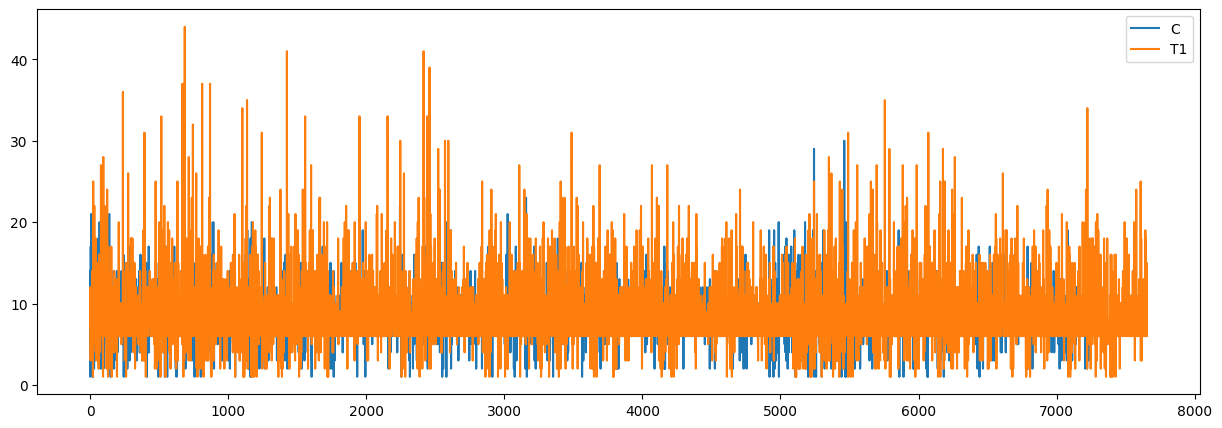

In [207]:
figure, ax = plt.subplots(figsize=(15, 5))
for treatment, treatment_sessions in sessions.groupby("treatment"):
    reindexed_treatment_sessions = treatment_sessions.sort_values("timestamp").reset_index()
    ax.plot(reindexed_treatment_sessions.index, reindexed_treatment_sessions["tracks"], label=treatment)
ax.legend()
pass

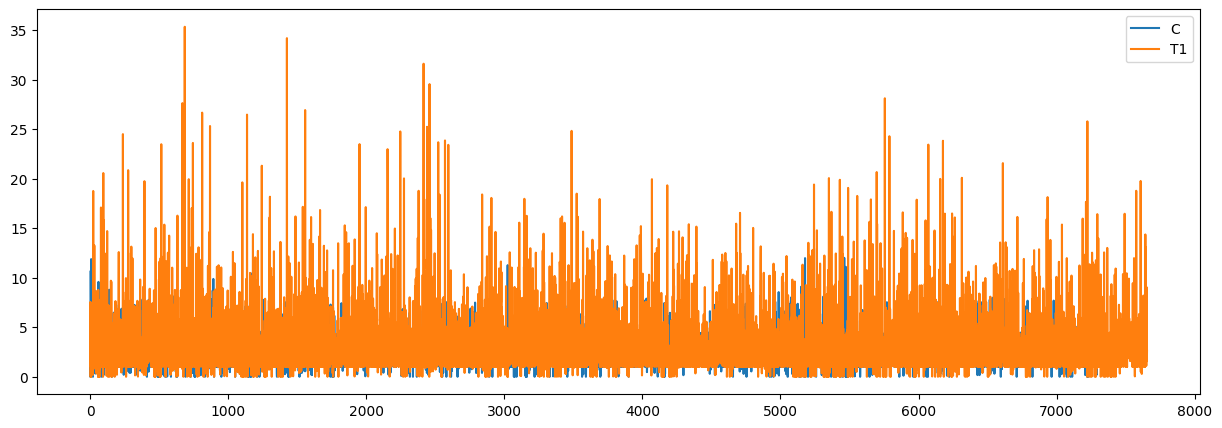

In [208]:
figure, ax = plt.subplots(figsize=(15, 5))
for treatment, treatment_sessions in sessions.groupby("treatment"):
    reindexed_treatment_sessions = treatment_sessions.sort_values("timestamp").reset_index()
    ax.plot(reindexed_treatment_sessions.index, reindexed_treatment_sessions["time"], label=treatment)
ax.legend()
pass

## Analyze the experiment

In [209]:
user_level_data = (
  sessions
    .reset_index()
    .groupby(["user", "treatment"])
    .agg(
        {
            "timestamp": "count",
            "tracks": "sum",
            "time": "sum",
            "latency": "sum"
        }
    )
)

user_level_data["sessions"] = user_level_data["timestamp"]
user_level_data["mean_request_latency"] = user_level_data["latency"] / user_level_data["tracks"]
user_level_data["mean_tracks_per_session"] = user_level_data["tracks"] / user_level_data["sessions"]
user_level_data["mean_time_per_session"] = user_level_data["time"] / user_level_data["sessions"]

metrics = [
    "time", 
    "sessions", 
    "mean_request_latency", 
    "mean_tracks_per_session", 
    "mean_time_per_session"
]

user_level_metrics = user_level_data[metrics].copy().reset_index()

In [210]:
treatment_level_metrics = (
    user_level_metrics
    .groupby("treatment")[metrics]
    .agg(["count", "mean", "var"])
)

In [211]:
def dof(n_0, n_1, s2_0, s2_1):
    numerator = (s2_0 / n_0 + s2_1 / n_1) * (s2_0 / n_0 + s2_1 / n_1)
    denominator = s2_0 * s2_0 / n_0 / n_0 / (n_0 - 1) + s2_1 * s2_1 / n_1 / n_1 / (n_1 - 1)
    return numerator / denominator


def ci(n_0, n_1, s2_0, s2_1, alpha=0.05):
    return ss.t.ppf(1 - alpha/2, dof(n_0, n_1, s2_0, s2_1)) * np.sqrt(s2_0 / n_0 + s2_1 / n_1)


effects = []

control = [data for treatment, data in treatment_level_metrics.iterrows() if treatment == "C"][0]

for treatment, row in treatment_level_metrics.iterrows():
    if treatment == "C":
        continue
    
    for metric in metrics:
        control_mean = control[metric]["mean"]
        treatment_mean = row[metric]["mean"]
        
        effect = treatment_mean - control_mean
        conf_int = ci(
            control[metric]["count"],
            row[metric]["count"],
            control[metric]["var"],
            row[metric]["var"],
        )
        effects.append({
            "treatment": treatment,
            "metric": metric,
            "control_mean": control_mean,
            "treatment_mean": treatment_mean,
            "effect": effect / control_mean * 100,
            "lower": (effect - conf_int) / control_mean * 100,
            "upper": (effect + conf_int) / control_mean * 100,
            "significant": (effect + conf_int) * (effect - conf_int) > 0
        })

In [212]:
def color(value):
    return 'color:red;' if value < 0 else 'color:green;'

def background(value):
    return 'color:white;background-color:green' if value else 'color:white;background-color:red'
        

(
    pd.DataFrame(effects)[[
        "treatment", 
        "metric",
        "effect", 
        "upper", 
        "lower", 
        "control_mean",
        "treatment_mean",
        "significant"
    ]]
    .sort_values(["metric", "treatment"], ascending=False)
    .style
    .applymap(color, subset=["effect", "upper", "lower"])
    .applymap(background, subset=["significant"])
)

,treatment,metric,effect,upper,lower,control_mean,treatment_mean,significant
0,T1,time,19.807,25.827,13.787,8.354,10.008,True
1,T1,sessions,3.971,8.167,-0.225,2.801,2.912,False
3,T1,mean_tracks_per_session,6.068,7.539,4.597,7.959,8.442,True
4,T1,mean_time_per_session,15.730,19.307,12.154,2.970,3.437,True
2,T1,mean_request_latency,22.636,24.393,20.878,11.173,13.702,True
